# Bias correct indices for HydroTas 2020-2021 workplan:
- Skill assessment
  - rainfall, surface temp and surface wind over Australia region and Tasmania region
  - Assess skill as function of start month and ensemble size
- UNSEEN
  - Tasmanian rainfall and Melbourne surface temperature

In [1]:
import xarray as xr
import myfuncs as my

# Parameters

In [2]:
CLIM_PERIOD = slice('1990-01-01', '2019-12-31')
REGIONS = ['AUS', 'MEL', 'TAS']
PARAMS = {'precip': 
             {'obsv_file': 'data/awap_precip_{region}.zarr',
              'fcst_file': 'data/f6_precip_{region}_raw.zarr',
              'obsv_scale': 1, 
              'fcst_scale': 86400,
              'method': 'multiplicative'},
          't_ref':
             {'obsv_file': 'data/jra55_t_ref_{region}.zarr',
              'fcst_file': 'data/f6_t_ref_{region}_raw.zarr',
              'obsv_scale': 1, 
              'fcst_scale': 1,
              'method': 'additive'},
          'V_ref':
             {'obsv_file': 'data/jra55_V_ref_{region}.zarr',
              'fcst_file': 'data/f6_V_ref_{region}_raw.zarr',
              'obsv_scale': 1, 
              'fcst_scale': 1,
              'method': 'multiplicative'}}

# Apply correction

In [3]:
def _effify(s):
    "Evaluate as f string. This is dangerous with untrusted input"
    return eval(f'f"""{s}"""')

In [4]:
for variable, params in PARAMS.items():
    for region in REGIONS:
        obsv = my.open_zarr(_effify(params['obsv_file'])).compute() * params['obsv_scale']
        fcst = my.open_zarr(_effify(params['fcst_file'])).compute() * params['fcst_scale']
        
        bias = my.get_bias(fcst, obsv, CLIM_PERIOD, method=params['method'])
        fcst_bc = my.remove_bias(fcst, bias)
        
        my.to_zarr(bias, _effify(params['fcst_file']).replace('raw','bias'))
        my.to_zarr(fcst_bc, _effify(params['fcst_file']).replace('_raw',''))

# Check the correction

In [5]:
fcst = my.open_zarr('data/f6_t_ref_AUS.zarr.zip')['t_ref']
obsv = my.open_zarr('data/jra55_t_ref_AUS.zarr.zip')['t_ref']

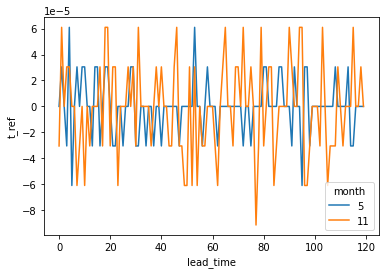

In [6]:
my.get_bias(fcst, obsv, CLIM_PERIOD, 
            method='additive').plot.line(x='lead_time')

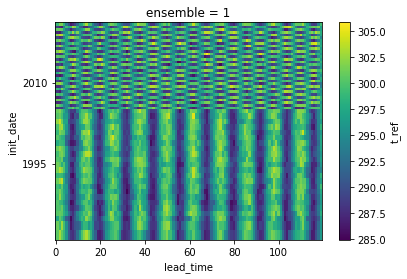

In [7]:
fcst.isel(ensemble=0).plot()

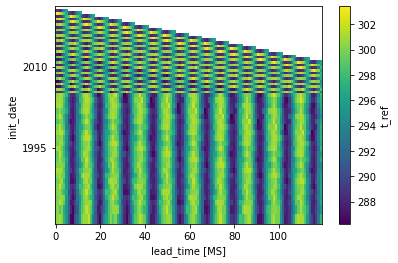

In [8]:
obsv.plot()